In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Problem 3
(12 points)

We ask a poplutaion of $\mathcal{P}$ persons a yes/no question every week for three year and record the number of yes answers. Every persons answer is assumed to be independent of each other. We model the probability of any single person answering yes in week $t$ as $\alpha_t$, and assume the following dynamics for this process,
$$
    \alpha_{t+1} = \left(1 + \exp\left[ - a \cdot \log \left( \frac{\alpha_t}{1 - \alpha_t} \right) + \sigma \cdot \eta_{t+1} \right] \right)^{-1}, \quad \eta_{t+1} \sim \mathcal{N}(0,1)
$$
we let $\alpha_1 \sim \mathcal{U}(0,1)$ (_uniform distribution_).

**a)** We are interested in estimating the probabilities $\alpha_t$ given the sum of yes answers $y_{1:t}$, since this is a non-linear non-Gaussian model we will use a *bootstrap particle filter* to solve this problem. To implement such an algorithm we need to perform three operations, propagation, weighting, and resampling. In this first problem you should do the following:
1. Find the conditional distribution of $y_t \mid \alpha_t$.
2. Implement a function that takes $N$ particles $\alpha_t^i$ and propagates them to $\alpha_{t+1}^{i}$.
3. Implement a function that takes $N$ particles $\alpha_t^i$ and an observation $y_t$ and calculates the log-weights $\log \omega_t^i$.
<div style='text-align: right'>(4p)</div>

**Solution:**

In [8]:
from scipy.stats import norm

#all the code here are developed from teacher's explanation, there is no 'official code'
def propagate(alphat,N,alpha,sigma):
    exp_part = np.exp(-alpha*np.log(alphat/(1-alphat))+sigma*np.random.normal(0,1,size=N))
    return 1/(1+exp_part)

# yt|alpha_t is binomial(P,alpha_t)
# the log-likelihood of given Yt=y is y*log(alphat)+(P-y)log(1-alphat)
# the log-likelihood value will be the value of log-weight
def log_weight(y,alphat,P):
    return y*np.log(alphat)+(P-y)*np.log(1-alphat)

___

**b)** using the functions from the previous part implement a **botstrap particle filter** that runs on the data available in the file `data_problem3.csv`. Use the parameter values $a = 0.9, \sigma = 0.5$, and $\mathcal{P} = 130$. 

Provide a plot of your estimate of the sequences $\mathbb{E}[\alpha_t \mid y_{1:t}]$ and $\mathbb{P}(\alpha_t > 0.5 \mid y_{1:t})$, for $t = 1, 2, \ldots, 156$. You should use at least $N = 200$ particles in your estimates.

_hint: note that $\mathbb{P}(\alpha_t > 0.5 \mid y_{1:t}) = \mathbb{E}[ I\{\alpha_t > 0.5\} \mid y_{1:t}]$, where $I\{ \cdot \}$ is an indicator function that is $1$ when the condition is satisfied and $0$ otherwise._
(_if you failed to solve part a you can use `propagate_wrong` and `logwgtfun_wrong` from `tssltools.py`_)
<div style="text-align: right"> (5p) </div>

In [9]:
data = pd.read_csv('data_problem3.csv',header=0)
y = data['Data'].values

**Solution:**

In [10]:
from tssltools import exp_norm 

def ESS(logw):
    ess = (sum(logw)**2)/(sum(logw**2))
    return ess
def bpf(y, numParticles, alpha, sigma, P):
    n = len(y)
    N = numParticles
    
    # Allocate memory
    particles = np.zeros((N, n), dtype = float)  # All generated particles
    logW = np.zeros((N, n))  # Unnormalized log-weight
    W = np.zeros((N, n))  # Normalized weight
    alpha_filt = np.zeros(n)  # Store filter mean
    N_eff = np.zeros(n)  # Efficient number of particles
    logZ = 0.  # Log-likelihood estimate

    # Filter loop
    for t in range(n):
        # Sample from "bootstrap proposal"
        if t == 0:  # Initialize from prior
            particles[:, 0] = np.random.rand(N)
        else:  # Resample and propagate according to dynamics
            ind = np.random.choice(N, N, replace=True, p=W[:, t-1])
            resampled_particles = particles[ind, t-1] 
            particles[:, t] = propagate(resampled_particles,N,alpha,sigma)

        # Compute weights
        logW[:, t] = log_weight(y[t],particles[:, t],P=P) 
        W[:, t], logZ_now = exp_norm(logW[:, t])
        # l(y1:n) = sum(ct)+log(capital_omiga_t_tilde)-log(N)
        
        # logZ_now = ct+log()
        logZ +=  (logZ_now-np.log(N)) # Update log-likelihood estimate
        
        N_eff[t] = ESS(W[:,t])

        # Compute filter estimates
        alpha_filt[t] = np.sum(W[:,t] * particles[:, t]) 
        
    return alpha_filt, particles, W, N_eff, logZ, n

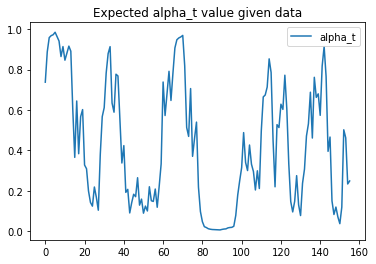

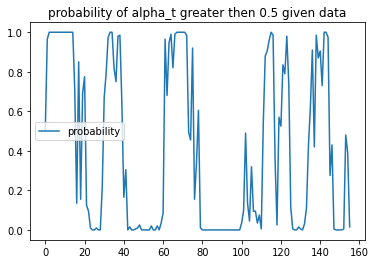

In [11]:
alpha_filt, particles, W, N_eff, logZ, n = bpf(y,200,0.9,0.5,130)
greater_than_onehalf = [sum(particles[:,x]>0.5)/200 for x in range(n)]
u = data.iloc[:,0].values
plt.plot(u,alpha_filt,label = 'alpha_t')
plt.title('Expected alpha_t value given data')
plt.legend()
plt.show()

plt.plot(u,greater_than_onehalf,label = 'probability')
plt.title('probability of alpha_t greater then 0.5 given data')
plt.legend()
plt.show()


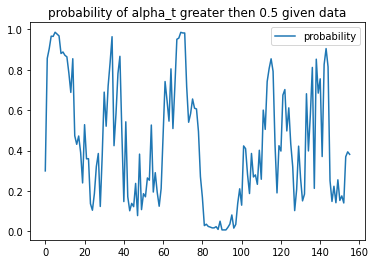

In [13]:
plt.plot(particles[1,:],label = 'probability')
plt.title('probability of alpha_t greater then 0.5 given data')
plt.legend()
plt.show()

___

**c)** The parameter $a$ is set quite arbitrary in the model above. In this problem you should perform parameter inference on this parameter. Find the value of $a$ by calculating the log-likelihood for different values of $a$, you know that the value is between $0.5$ and $1$. Find an estimate of $a$ that would be within $0.05$ of the true value.
<div style="text-align: right">(3p)</div> 

**Solution:**

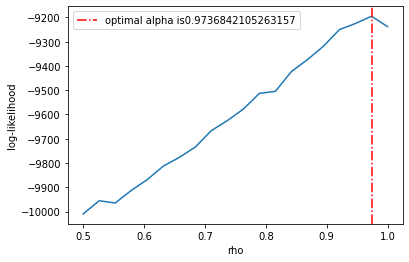

In [48]:
grid_list = np.linspace(0.5,1,num = 20)
res = np.zeros(20)
for i in range(20):
    multi_run = 0
    for j in range(5):
        _,_,_,_,logz,_ =bpf(y,200,grid_list[i],0.5,130)
        multi_run += logz
    res[i] = multi_run/5
    
plt.plot(grid_list,res)
plt.axvline(grid_list[np.argmax(res)],linestyle='-.',color = 'red',label = 'optimal alpha is{}'.format(grid_list[np.argmax(res)]))
plt.xlabel('rho')
plt.legend()
plt.ylabel('log-likelihood')
plt.show()